In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from PIL import Image
import os
import csv
from skimage import io
work_dir = "/kaggle/input/birds-22wi/birds"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

cuda:0


In [2]:
class TestImageDataSet(Dataset):

    def __init__(self, label_csv_file, root_dir, fileNames, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.true_label_csv = label_csv_file
        self.true_label_map = {}
        self.fileNameList = fileNames
        self.root_dir = root_dir
        self.transform = transform
#         self.parseLabelsToDict()
        
    def parseLabelsToDict(self):
        with open(self.true_label_csv, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                path = row["path"]
                classes = row["class"]
                self.true_label_map[path] = classes
            csvfile.close()
            
    def __len__(self):
        return len(self.fileNameList)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.fileNameList[idx])
        image = Image.open(img_name)
        
        
        item = [image, self.fileNameList[idx]]
        if self.transform:
            item[0] = self.transform(item[0])
        return item[0], item[1]

In [3]:
def get_birds_data():
    # Data augmentation transformations. Not for Testing!
    transform_train = transforms.Compose([
        transforms.Resize(64), # Takes images smaller than 64 and enlarges them
        transforms.RandomCrop(64, padding=4, padding_mode='edge'), # Take 64x64 crops from 72x72 padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])

    transform_test = transforms.Compose([
        transforms.Resize([64,64]),
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.ImageFolder(root='/kaggle/input/birds-22wi/birds/train/', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testFileNames = os.listdir("/kaggle/input/birds-22wi/birds/test/0")
    testset = TestImageDataSet(label_csv_file="/kaggle/input/birds-22wi/birds/labels.csv", 
                               root_dir='/kaggle/input/birds-22wi/birds/test/0', fileNames=testFileNames, transform=transform_test)
#     testset = torchvision.datasets.ImageFolder(root='/kaggle/input/birds-22wi/birds/test/', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    return {'train': trainloader, 'test': testloader}

data = get_birds_data()

128
torch.Size([8, 3, 64, 64])


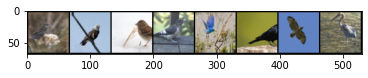

Labels:tensor(386) tensor(3) tensor(545) tensor(516) tensor(331) tensor(49) tensor(439) tensor(67)
torch.Size([8, 3, 64, 64])
torch.Size([8, 12288])


In [4]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
print(len(images))
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ' '.join('%9s' % labels[j] for j in range(8)))

flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

In [5]:
class ConvBNNet(nn.Module):
    def __init__(self):
        super(ConvBNNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256, 555)

    def forward(self, x):
        # Input 64x64x3

        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2) # 32x32x16
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2) # 16x16x32
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2) # 8x8x64
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2) # 4x4x128
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2) # 2x2x256

        # Global average pooling across each channel (Input could be 2x2x256, 4x4x256, 7x3x256, output would always be 256 length vector)
        x = F.adaptive_avg_pool2d(x, 1)                                            # 1x1x256
        x = torch.flatten(x, 1)                                                    # vector 256
        
        x = self.fc1(x)
        return x

In [6]:
def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
    net.to(device)
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    for epoch in range(epochs):
        sum_loss = 0.0
        for i, batch in enumerate(dataloader, 0):
            
            inputs, labels = batch[0].to(device), batch[1].to(device)
            
            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            sum_loss += loss.item()
            if i % 100 == 99:
                if verbose:
                    print('[%d, %5d] loss: %.3f' %
                         (epoch + 1, i + 1, sum_loss / 100))
                sum_loss = 0.0
    return losses

def evaluate(net, dataloader):
    net.to(device)
    net.eval()
    count = 1
    df = pd.DataFrame(columns=['path', "class"])
    with torch.no_grad():
        for batch in dataloader:
            print("batch:", count)
            count += 1
            images = batch[0].to(device)
            names = batch[1]
            outputs = net(images)
            print(outputs.data[0].shape)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()
            for i in range(len(predicted)):
                df = df.append({"path": "test/" + names[i], "class" : predicted[i].item()}, ignore_index=True)
            
    return df
def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')

[1,   100] loss: 6.244
[1,   200] loss: 5.885
[1,   300] loss: 5.687
[2,   100] loss: 5.482
[2,   200] loss: 5.332
[2,   300] loss: 5.191
[3,   100] loss: 4.982
[3,   200] loss: 4.900
[3,   300] loss: 4.785
[4,   100] loss: 4.593
[4,   200] loss: 4.525
[4,   300] loss: 4.436
[5,   100] loss: 4.271
[5,   200] loss: 4.237
[5,   300] loss: 4.183
[6,   100] loss: 4.017
[6,   200] loss: 4.054
[6,   300] loss: 4.013
[7,   100] loss: 3.863
[7,   200] loss: 3.842
[7,   300] loss: 3.808
[8,   100] loss: 3.679
[8,   200] loss: 3.730
[8,   300] loss: 3.691
[9,   100] loss: 3.552
[9,   200] loss: 3.592
[9,   300] loss: 3.612
[10,   100] loss: 3.419
[10,   200] loss: 3.468
[10,   300] loss: 3.555
[11,   100] loss: 3.335
[11,   200] loss: 3.427
[11,   300] loss: 3.384
[12,   100] loss: 3.297
[12,   200] loss: 3.333
[12,   300] loss: 3.342
[13,   100] loss: 3.201
[13,   200] loss: 3.288
[13,   300] loss: 3.295
[14,   100] loss: 3.134
[14,   200] loss: 3.199
[14,   300] loss: 3.226
[15,   100] loss: 3

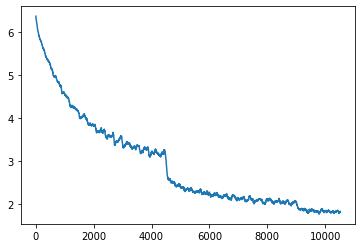

In [7]:
final_net = ConvBNNet()

final_losses =  train(final_net, data['train'], epochs=15, lr=.1  , decay=.0005)
final_losses += train(final_net, data['train'], epochs=15, lr=.01 , decay=.0005)
final_losses += train(final_net, data['train'], epochs=5, lr=.001, decay=.0005)


plt.plot(smooth(final_losses, 50))

#print("Training accuracy: %f" % accuracy(final_net, data['train']))
#print("Testing  accuracy: %f" % accuracy(final_net, data['test']))

In [8]:
result = evaluate(final_net, data["test"])
print(result.head())

batch: 1
torch.Size([555])
batch: 2
torch.Size([555])
batch: 3
torch.Size([555])
batch: 4
torch.Size([555])
batch: 5
torch.Size([555])
batch: 6
torch.Size([555])
batch: 7
torch.Size([555])
batch: 8
torch.Size([555])
batch: 9
torch.Size([555])
batch: 10
torch.Size([555])
batch: 11
torch.Size([555])
batch: 12
torch.Size([555])
batch: 13
torch.Size([555])
batch: 14
torch.Size([555])
batch: 15
torch.Size([555])
batch: 16
torch.Size([555])
batch: 17
torch.Size([555])
batch: 18
torch.Size([555])
batch: 19
torch.Size([555])
batch: 20
torch.Size([555])
batch: 21
torch.Size([555])
batch: 22
torch.Size([555])
batch: 23
torch.Size([555])
batch: 24
torch.Size([555])
batch: 25
torch.Size([555])
batch: 26
torch.Size([555])
batch: 27
torch.Size([555])
batch: 28
torch.Size([555])
batch: 29
torch.Size([555])
batch: 30
torch.Size([555])
batch: 31
torch.Size([555])
batch: 32
torch.Size([555])
batch: 33
torch.Size([555])
batch: 34
torch.Size([555])
batch: 35
torch.Size([555])
batch: 36
torch.Size([555])
b

In [9]:
result.to_csv("output.csv", index = False)